## Speech Commands Recognition
  

In [1]:
import os
import tarfile
import urllib.request

DATASET_URL = "http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
data_dir = './data'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)


dataset_path = os.path.join(data_dir, 'speech_commands_v0.02.tar.gz')
urllib.request.urlretrieve(DATASET_URL, dataset_path)


with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall(path=data_dir)

print("Dataset downloaded and extracted.")


Dataset downloaded and extracted.


In [10]:
import tensorflow as tf
import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt
from IPython import display
import librosa


AUTOTUNE = tf.data.AUTOTUNE


In [30]:
data_dir = pathlib.Path("./data")

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)


Commands: ['learn' 'on' 'down' 'follow' 'cat' '.DS_Store' 'three' 'forward' 'up'
 'no' 'sheila' 'stop' 'tree' 'zero' 'LICENSE' 'six' 'four'
 'validation_list.txt' 'seven' 'one' 'right' 'off' 'marvin' 'five' 'dog'
 'two' 'go' 'left' 'testing_list.txt' 'wow' 'bird' 'backward' 'house'
 'visual' 'happy' 'nine' '_background_noise_'
 'speech_commands_v0.02.tar.gz' 'eight' 'bed' 'yes']


In [31]:

# Extract command labels from the dataset directory
commands = np.array(tf.io.gfile.listdir(data_dir))
commands = commands[commands != 'README.md']  # Remove README.md if present

print(f"Commands on which the model was trained:")
for i, command in enumerate(commands):
    print(f"{i + 1}. {command}")

Commands on which the model was trained:
1. learn
2. on
3. down
4. follow
5. cat
6. .DS_Store
7. three
8. forward
9. up
10. no
11. sheila
12. stop
13. tree
14. zero
15. LICENSE
16. six
17. four
18. validation_list.txt
19. seven
20. one
21. right
22. off
23. marvin
24. five
25. dog
26. two
27. go
28. left
29. testing_list.txt
30. wow
31. bird
32. backward
33. house
34. visual
35. happy
36. nine
37. _background_noise_
38. speech_commands_v0.02.tar.gz
39. eight
40. bed
41. yes


In [32]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    label = get_label(file_path)
    return waveform, label


files = tf.io.gfile.glob(str(data_dir) + '/*/*.wav')
files = tf.random.shuffle(files)

print("Number of audio files:", len(files))


files_ds = tf.data.Dataset.from_tensor_slices(files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


Number of audio files: 105835


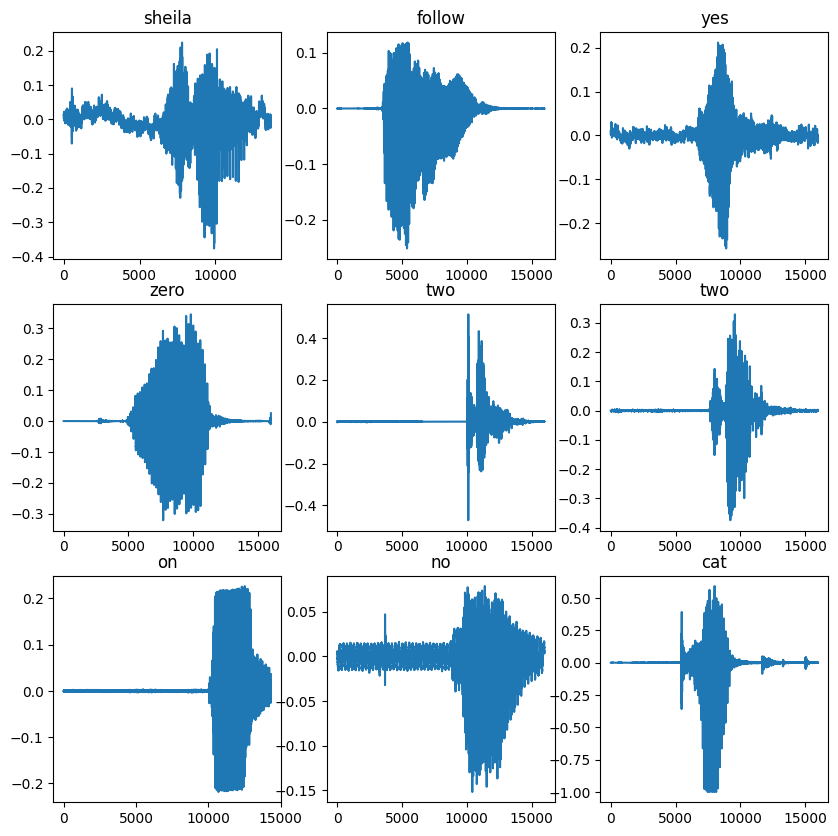

In [33]:
rows = 3
cols = 3
n = rows * cols
waveforms, labels = zip(*[(waveform.numpy(), label.numpy().decode('utf-8')) for waveform, label in waveform_ds.take(n)])

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (waveform, label) in enumerate(zip(waveforms, labels)):
    r = i // cols
    c = i % cols
    axes[r][c].plot(waveform)
    axes[r][c].set_title(label)

plt.show()


In [34]:
def get_spectrogram(waveform):

    waveform = tf.signal.frame(waveform, frame_length=16000, frame_step=16000, pad_end=True)
    waveform = tf.reshape(waveform, [-1])

    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)


    spectrogram = tf.image.resize(spectrogram, [161, 101])

    return spectrogram


def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


In [35]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
SAMPLE_RATE = 16000  # Hz
FIXED_LENGTH = SAMPLE_RATE  # 1 second

In [36]:
def visualize_waveforms_and_spectrograms(waveform_ds, spectrogram_ds, commands, n=9):
    # Take n samples from the dataset
    vis_waveform_ds = waveform_ds.take(n)
    vis_spectrogram_ds = spectrogram_ds.take(n)
    waveforms, labels = zip(*[(waveform.numpy(), label.numpy().decode('utf-8')) for waveform, label in vis_waveform_ds])
    spectrograms, _ = zip(*[(spectrogram.numpy(), label_id.numpy()) for spectrogram, label_id in vis_spectrogram_ds])

    # Generate spectrograms for visualization
    spectrograms_db = []
    for spectrogram in spectrograms:
        spectrogram = spectrogram.squeeze()
        spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
        spectrograms_db.append(spectrogram_db)

    # Plot Waveforms and Spectrograms
    rows, cols = 3, 6  # 3 rows, 6 columns (3 waveforms + 3 spectrograms)
    fig, axes = plt.subplots(rows, cols, figsize=(24, 12))
    fig.suptitle('Waveforms and Spectrograms', fontsize=24, fontweight='bold')

    for i in range(n):
        r = i // 3
        c = i % 3

        # Plot Waveform
        ax_waveform = axes[r][c * 2]
        ax_waveform.plot(waveforms[i], color='steelblue')
        ax_waveform.set_title(f'Waveform: {labels[i]}', fontsize=12)
        ax_waveform.set_xlabel('Sample Index', fontsize=10)
        ax_waveform.set_ylabel('Amplitude', fontsize=10)
        ax_waveform.grid(True, linestyle='--', alpha=0.5)

        # Plot Spectrogram
        ax_spectrogram = axes[r][c * 2 + 1]
        img = ax_spectrogram.imshow(
            spectrograms_db[i],
            aspect='auto',
            origin='lower',
            cmap='magma',
            extent=[0, FIXED_LENGTH/SAMPLE_RATE, 0, SAMPLE_RATE/2]
        )
        ax_spectrogram.set_title(f'Spectrogram: {labels[i]}', fontsize=12)
        ax_spectrogram.set_xlabel('Time (s)', fontsize=10)
        ax_spectrogram.set_ylabel('Frequency (Hz)', fontsize=10)
        fig.colorbar(img, ax=ax_spectrogram, format="%+2.f dB")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


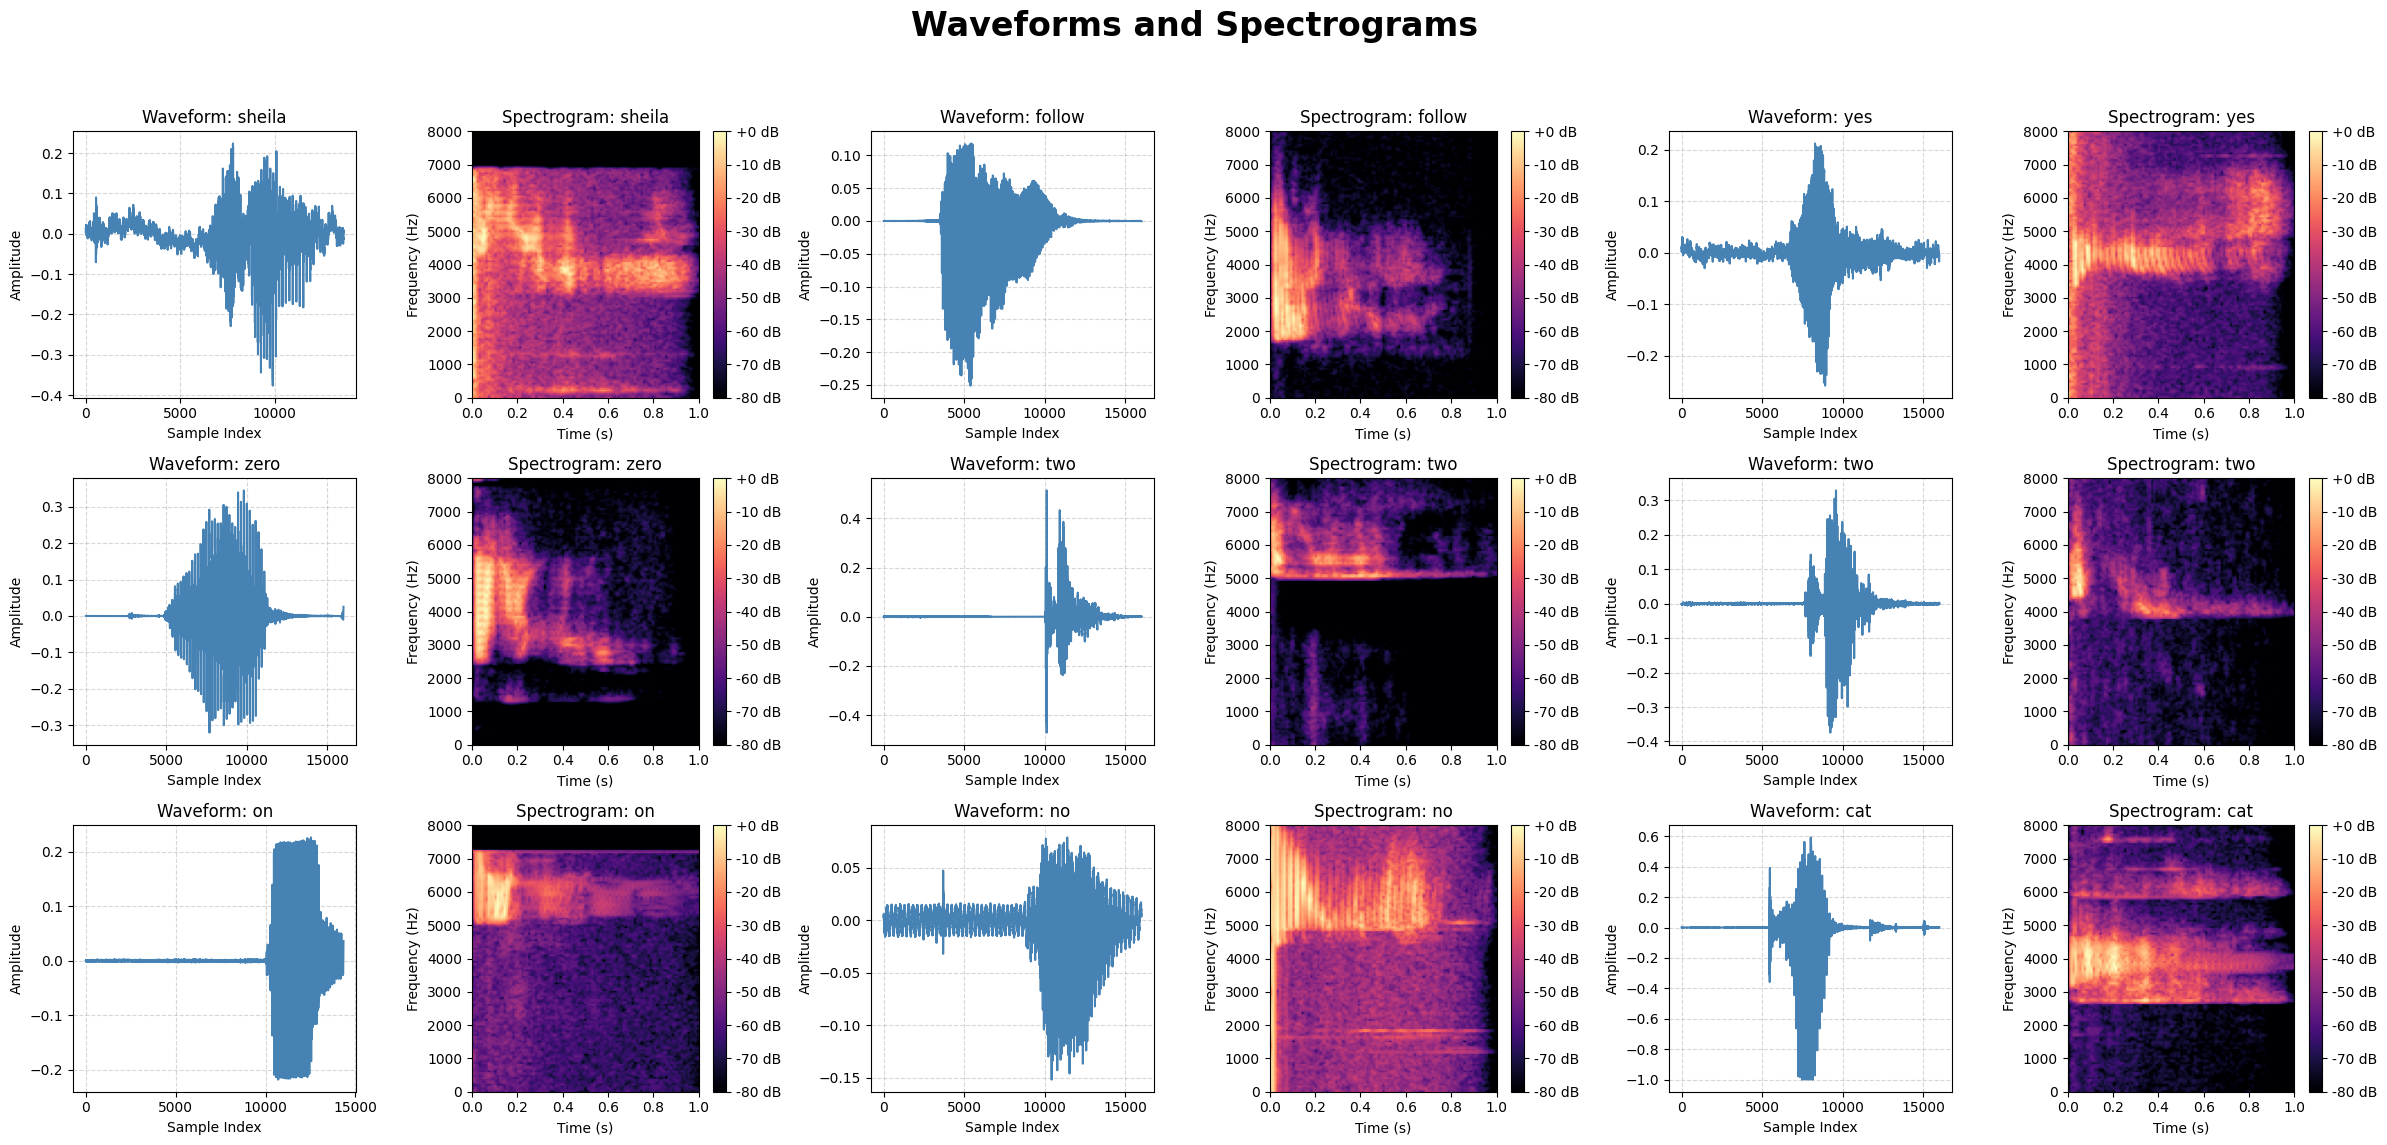

In [37]:
visualize_waveforms_and_spectrograms(waveform_ds, spectrogram_ds, commands, n=9)


In [38]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return output_ds

total_files = len(files)
train_size = int(0.8 * total_files)
val_size = int(0.1 * total_files)
test_size = total_files - train_size - val_size

train_files = files[:train_size]
val_files = files[train_size:train_size+val_size]
test_files = files[train_size+val_size:]

print(f"Total files: {total_files}")
print(f"Train files: {len(train_files)}")
print(f"Validation files: {len(val_files)}")
print(f"Test files: {len(test_files)}")

# Create datasets
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

# Batch the datasets
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Use buffered prefetching
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)
# train_files = files[:int(len(files) * 0.8)]
# val_files = files[int(len(files) * 0.8):]
# test_files = files[int(len(files) * 0.2):]

# train_ds = preprocess_dataset(train_files)
# val_ds = preprocess_dataset(val_files)
# test_ds= preprocess_dataset(test_files)

# batch_size = 64
# train_ds = train_ds.batch(batch_size)
# val_ds = val_ds.batch(batch_size)
# test_ds = test_ds.batch(batch_size)


Total files: 105835
Train files: 84668
Validation files: 10583
Test files: 10584


In [39]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)


model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(161, 101, 1), batch_size=32),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(commands))

])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()


Input shape: (161, 101, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (32, 159, 99, 32)           │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 79, 49, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 77, 47, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 38, 23, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 36, 21, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 18, 10, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (32, 23040)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 128)                   │       2,949,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 41)                    │           5,289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,047,209 (11.62 MB)

 Trainable params: 3,047,209 (11.62 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
EPOCHS = 5
history = model.fit(
    train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE),
    validation_data=val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE),
    epochs=EPOCHS
)

Epoch 1/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 187s 136ms/step - accuracy: 0.5046 - loss: 1.8281 - val_accuracy: 0.8287 - val_loss: 0.6020
Epoch 2/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.8521 - loss: 0.5124 - val_accuracy: 0.8516 - val_loss: 0.5390
Epoch 3/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9061 - loss: 0.3137 - val_accuracy: 0.8575 - val_loss: 0.5512
Epoch 4/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.9320 - loss: 0.2220 - val_accuracy: 0.8501 - val_loss: 0.6895
Epoch 5/5
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.9462 - loss: 0.1717 - val_accuracy: 0.8652 - val_loss: 0.7172


In [40]:
model.save('wavmodel.keras')


In [41]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.4f}")

166/166 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.0288 - loss: 3.7186
Test accuracy: 0.03
Test Loss: 3.7179


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Predicted command: one
Confidence: 0.03


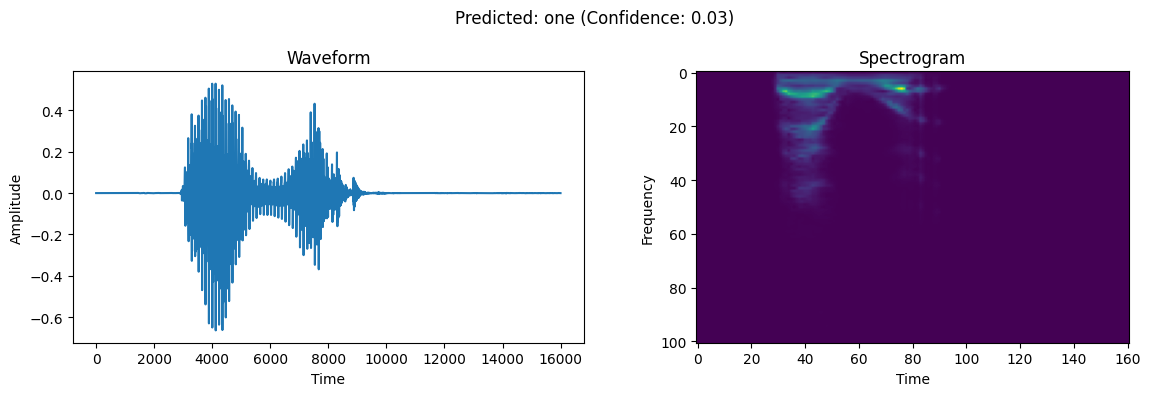

In [42]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa

def preprocess_audio_file(file_path, target_sample_rate=16000, target_duration=1.0):
    # Load the audio file
    audio, sample_rate = librosa.load(file_path, sr=None)

    # Resample if necessary
    if sample_rate != target_sample_rate:
        audio = librosa.resample(audio, orig_sr=sample_rate, target_sr=target_sample_rate)

    # Calculate target length
    target_length = int(target_sample_rate * target_duration)

    # Pad or truncate the audio to the target length
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    else:
        audio = audio[:target_length]

    return audio

def predict_audio(audio_file_path, model, commands):
    # Preprocess the audio file
    waveform = preprocess_audio_file(audio_file_path)
    spectrogram = get_spectrogram(waveform)
    spectrogram = tf.expand_dims(spectrogram, 0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(spectrogram)
    predicted_index = tf.argmax(predictions[0]).numpy()
    predicted_command = commands[predicted_index]
    confidence = tf.nn.softmax(predictions[0])[predicted_index].numpy()

    return predicted_command, confidence, waveform

def plot_prediction(waveform, predicted_command, confidence):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(waveform)
    plt.title('Waveform')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')

    # Plot spectrogram
    spectrogram = get_spectrogram(waveform)
    plt.subplot(1, 2, 2)
    plt.imshow(tf.transpose(spectrogram)[0])
    plt.title('Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.suptitle(f'Predicted: {predicted_command} (Confidence: {confidence:.2f})')
    plt.tight_layout()
    plt.show()

# Example usage:
audio_file_path = '/content/data/backward/02ade946_nohash_4.wav'  # Replace with an actual file path
predicted_command, confidence, waveform = predict_audio(audio_file_path, model, commands)
print(f"Predicted command: {predicted_command}")
print(f"Confidence: {confidence:.2f}")

plot_prediction(waveform, predicted_command, confidence)


In [43]:
# Get the number of classes from the model's output layer
num_classes = model.output_shape[-1]
print(f"Number of classes in the model: {num_classes}")


Number of classes in the model: 41


In [44]:
# Assume num_classes is determined as 36
num_classes = model.output_shape[-1]

if len(commands) != num_classes:
    if len(commands) > num_classes:
        print(f"Trimming 'commands' from {len(commands)} to {num_classes} labels.")
        commands = commands[:num_classes]
    else:
        print(f"'commands' has fewer labels ({len(commands)}) than the model's classes ({num_classes}).")
        # Optionally, handle missing labels or raise an error
        raise ValueError("The 'commands' array has fewer labels than the model's output classes.")
else:
    print("The 'commands' array matches the model's number of classes.")


The 'commands' array matches the model's number of classes.


Model expects 41 classes.
The 'commands' array matches the model's number of classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


<Figure size 1200x1000 with 0 Axes>

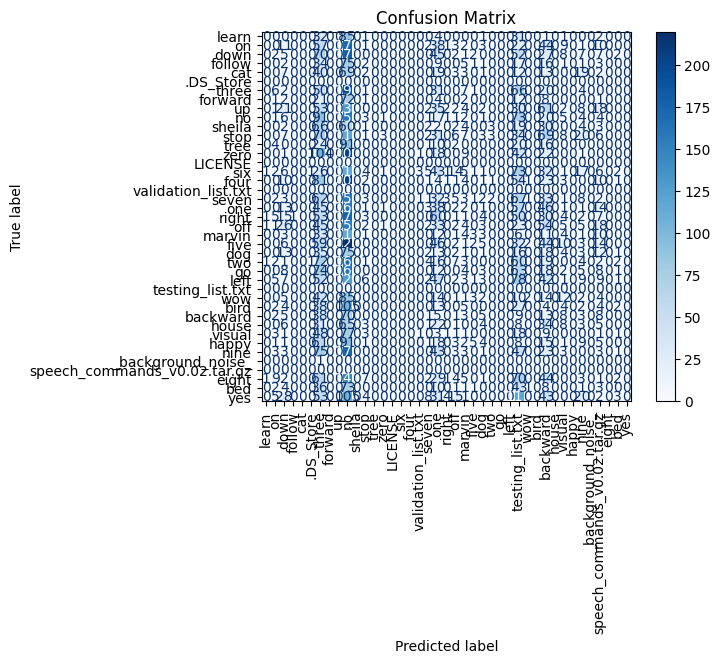

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to evaluate the model on the validation dataset
def evaluate_model_on_validation(model, val_ds, commands):
    # Determine the number of classes from the model
    num_classes = model.output_shape[-1]
    print(f"Model expects {num_classes} classes.")

    # Adjust 'commands' to match the number of classes
    if len(commands) != num_classes:
        if len(commands) > num_classes:
            print(f"Trimming 'commands' from {len(commands)} to {num_classes} labels.")
            commands = commands[:num_classes]
        else:
            print(f"'commands' has fewer labels ({len(commands)}) than the model's classes ({num_classes}).")
            raise ValueError("The 'commands' array has fewer labels than the model's output classes.")
    else:
        print("The 'commands' array matches the model's number of classes.")

    # Collect true labels and predictions
    y_true = []
    y_pred = []

    for spectrogram_batch, label_batch in val_ds:
        predictions = model.predict(spectrogram_batch)
        y_pred.extend(np.argmax(predictions, axis=1))  # Predicted labels
        y_true.extend(label_batch.numpy())  # True labels

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Compute accuracy
    accuracy = np.mean(y_true == y_pred)
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=commands)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
evaluate_model_on_validation(model, val_ds, commands)


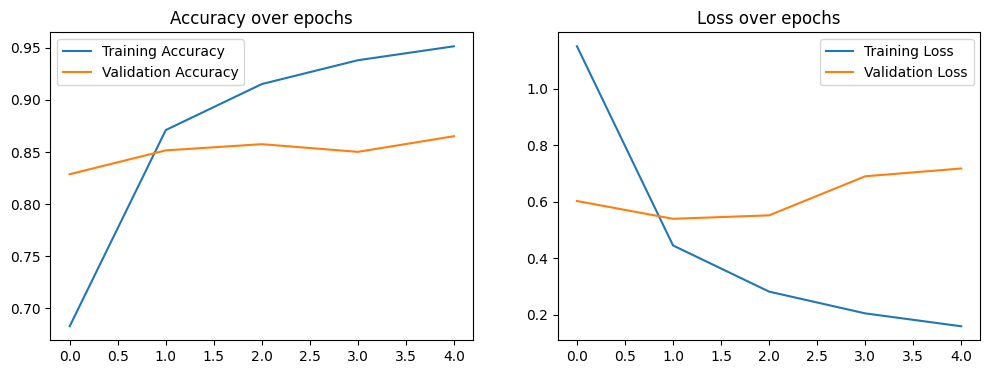

In [49]:
import matplotlib.pyplot as plt

# Plotting the accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()